In [50]:
######## PRELIMS #########

import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
from scipy.stats import norm
from scipy.interpolate import interp1d
import plotfancy as pf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from cycler import cycler
import argparse
from tqdm import tqdm
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
import gw150814_simulator as gs
from simulators.utils import *
from utils.module import CustomLossModule_withBounds, BCELossModule

pf.housestyle_rcparams()

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'
mygold = (218/255, 165/255, 64/255, 0.1)  

############ FUNCTIONs #########

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

def t_to_pvalue(ts, df=1):
    return 1 - scipy.stats.chi2.cdf(ts, df)

def t_to_pvalue_empirical(ts_obs, ts0_ref):
    ts0_ref = np.asarray(ts0_ref)
    return (np.sum(ts0_ref >= ts_obs) + 1) / (len(ts0_ref) + 1)

def dict_to_mps(x):
    if isinstance(x, dict):
        return {k: dict_to_mps(v) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(dtype=torch.float32,device='mps')
    elif isinstance(x, list):
        return [dict_to_mps(item) for item in x]
    else:
        return x

def dict_to_cpu(x: dict) -> dict:
    out = {}
    for key, val in x.items():
        if isinstance(val, torch.Tensor):
            out[key] = val.to(device='cpu')
        else:
            out[key] = val
    return out


def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_mps(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

def chop_middle(array, remove=50, linemode=True):
    if len(array)%2==0:
        mid_u = int(len(array)/2)
        mid_d = mid_u -1
        if not linemode:
            return np.concatenate([array[:mid_d-remove], array[mid_u+remove:]])
        else:
            return array[:mid_d-remove] , array[mid_u+remove:], array[mid_u]
    else:
        mid = len(array)//2
        if not linemode:
            return np.concatenate([array[:mid-remove], array[mid+remove:]])
        else:
            return array[:mid-remove], array[mid+remove:], array[mid]
        
def get_snr2(input:dict):
    target = input['x']
    snr2_nn = network_epsilon.snr(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy()**2 
    return snr2_nn

def local_do_ticks(list_of_axes, dir = 'in'):
    for ax in list_of_axes:
        ax.minorticks_on()
        ax.tick_params(top=True,right=True, direction=dir, length=7, which='major')
        ax.tick_params(top=True,right=True, direction=dir, length=4, which='minor')

def local_fix_frame(ax):
    ax.tick_params(color='black', labelcolor='black')
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(1)
    return True

def local_fix_plot(a, tickdir ='in'):
    for axes in a:
        axes.grid(False)
        local_do_ticks([axes], tickdir)
        local_fix_frame(axes)
    return True

quantiles = np.array([0.05199686, 0.2145543,  0.58780088, 1.17737921, 1.91882754,
 2.75067576, 3.63463655])

quantiles_long = np.array([7.11978022e-04, 7.96148769e-03, 5.19968566e-02, 2.14554300e-01,
 5.87800876e-01, 1.17737921e+00, 1.91882754e+00, 2.75067576e+00,
 3.63463655e+00, 4.55164698e+00, 5.49045819e+00])



In [3]:
glob_sigma = 1
glob_bkg = True
glob_det = 'stoch'
glob_mode = 'gw'

Nsims = 1
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float64, 
                               mode='gw', bump=glob_det, frange=[10,500])
simulator._init_gw()

Nbins = len(simulator.grid_chopped)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


In [4]:
netid = 'GW_bs_500'

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

In [5]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet
from models.unet_1d import UNet1d 

class Network_epsilon(torch.nn.Module):
    def __init__(self, nbins):
        super().__init__()
        
        self.nbins = nbins

        self.logvariance = torch.nn.Parameter(torch.ones(self.nbins)*5)

        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
        self.mu_predictor = torch.nn.Sequential(
            torch.nn.Linear(self.nbins, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.nbins)
        )

    def mu(self, x):
        x = self.mu_predictor(x.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        resd = x - self.mu(x)
        out = self.net(resd.unsqueeze(1)).squeeze(1) # x-net
        return out
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5

        
    def forward(self, x):
        
        x0_block = x['x0']
        mu_block = x['mu']
        ni = x['ni']
        
        ###########################################
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, 
                                                           device= x['x'].device, 
                                                           dtype= x['x'].dtype) - self.bounds()) * ni
        ###########################################

        data = x0_block+epsilon_sim
        
        # net evaluation_m
        net_mu = self.mu(data)
        error_mu = (net_mu-mu_block)**2
        l_mu = error_mu / (self.logvariance.exp() + 1e-10) + self.logvariance
        l_mu_return = l_mu.sum() * 0.5

        # net evaluation_e
        net_epsilon = self.epsilon(data)
        mask = ( ni != 0 )  
        squared_error_e = (net_epsilon - epsilon_sim)**2                                         # [B, N_bins]
        l_e = squared_error_e / (self.logvariance.exp() + 1e-21) + self.logvariance                   # [B, N_bins]
        l_e_return = (l_e * mask.float()).sum() * 0.5
        
        # combine
        return l_mu_return+l_e_return 

In [6]:
network_epsilon = Network_epsilon(Nbins)
checkpoint = torch.load(f'networks/network_{netid}_complex', 
                        weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
network_epsilon.load_state_dict(new_state_dict)
network_epsilon.cuda().double().eval()

model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
checkpoint = torch.load(f'networks/model_{netid}_complex', 
                        weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
model.load_state_dict(sd)
network_epsilon.cuda().double().eval()


Network_epsilon(
  (net): ResidualNet(
    (initial_layer): Conv1d(1, 128, kernel_size=(1,), stride=(1,))
    (blocks): ModuleList(
      (0-1): 2 x ResidualBlock(
        (conv_layers): ModuleList(
          (0-1): 2 x Conv1d(128, 128, kernel_size=(1,), stride=(1,))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layer): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
  )
  (mu_predictor): Sequential(
    (0): Linear(in_features=1960, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1960, bias=True)
  )
)

In [7]:
network_epsilon.cuda()
N_mc = 2e5

obs = simulator.sample(1)
ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 16*2
N_batch = int(N_mc / batch_size)

ts_bin_H0_epsilon = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch =  (network_epsilon.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
    ts_bin_H0_epsilon.append(ts_batch)
    
ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)

100%|██████████| 6250/6250 [05:12<00:00, 19.97it/s]


In [205]:
def pvalue_grid_eps(dat):
    eps_t_mean = np.mean(ts_bin_H0_epsilon, axis=0)
    eps_t_ref = ts_bin_H0_epsilon - eps_t_mean
    counts = np.sum(eps_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(eps_t_ref) + 1)

def pvalue_grid_BCE(dat):
    BCE_t_mean = np.mean(ts_bin_H0_BCE, axis=0)
    BCE_t_ref = ts_bin_H0_BCE - BCE_t_mean
    counts = np.sum(BCE_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(BCE_t_ref) + 1)

def chop_middle(array, remove=5, linemode=True):
    if len(array)%2==0:
        mid_u = int(len(array)/4)
        mid_d = mid_u -1
        if not linemode:
            return np.concatenate([array[:mid_d-remove], array[mid_u+remove:]])
        else:
            return array[:mid_d-remove] , array[mid_u+remove:], array[mid_u]
    else:
        mid = len(array)//2
        if not linemode:
            return np.concatenate([array[:mid-remove], array[mid+remove:]])
        else:
            return array[:mid-remove], array[mid+remove:], array[mid]
        
def get_snr2(input:dict):
    target = input['x']
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy()**2 
    return snr2_nn

def local_do_ticks(list_of_axes, dir = 'in'):
    for ax in list_of_axes:
        ax.minorticks_on()
        ax.tick_params(top=True,right=True, direction=dir, length=7, which='major')
        ax.tick_params(top=True,right=True, direction=dir, length=4, which='minor')

def local_fix_frame(ax):
    ax.tick_params(color='black', labelcolor='black')
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(1)
    return True

def local_fix_plot(a, tickdir ='in'):
    for axes in a:
        axes.grid(False)
        local_do_ticks([axes], tickdir)
        local_fix_frame(axes)
    return True

/tmp/ipykernel_99731/1292973665.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


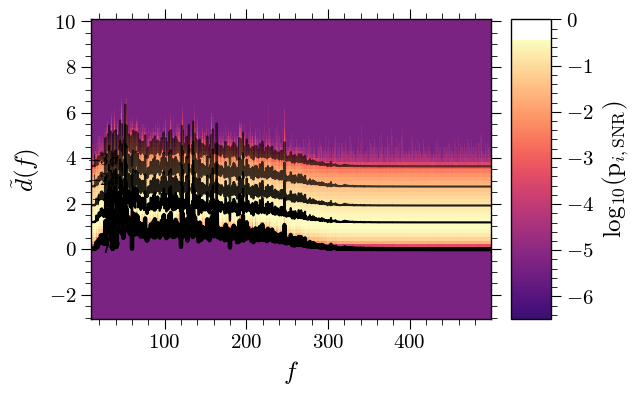

In [206]:
###### SET UP GRID ######
positions = torch.tensor(np.array(simulator.grid_chopped))
amplitudes = torch.linspace(-3, 10, 80).to(dtype=simulator.dtype)

position_grid, amplitude_grid = torch.meshgrid(positions,amplitudes)
b = {'x':amplitude_grid.T}

###### DO BCE STATS ######
a = b['x']
s = get_snr2(b)
dat = [a,s]


fig, ax1 = pf.create_plot()
ax1.set_xlabel(r'$f$')
ax2 = fig.add_axes((1.05, 0,0.1,1))

# ax3 = fig.add_axes((0, 1.1,1,1))
# plt.setp(ax3.get_xticklabels(), visible=False)
# ax4 = fig.add_axes((1.05, 1.1,0.1,1))

axs = [ax1,ax2]


dat = [pvalue_grid_eps(s)]
lab =  [r'$\mathrm{log}_{10}($p$_{i, \mathrm{SNR}})$']

labcolour = "#000000"

obs = simulator.sample(100)

plot = np.log10(dat[q])
mask = amplitudes<0
plot[mask] = -5.30103217


for q in range(1):
    mesh = axs[2*q].pcolormesh(position_grid.T, amplitude_grid.T, plot, cmap='magma', vmin=-8)
    fig.colorbar(mesh,cax=axs[2*q+1], shrink=0.8, label=lab[q])
    axs[2*q+1].set_ylim([-6.5,0])

    for j in range(2):
        axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0])[j], color=labcolour, linewidth=3)
        for i in range(5):
            alp = .5+(i/8)
            axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0]+quantiles[-i])[j], color=labcolour, alpha=alp)

    x = 25
    axs[2*q].text(x,obs['mu'][0][int(x)], r'$\mu$', color=labcolour, size=20)
    sigs = [r'$+3\sigma$',r'$+2\sigma$',r'$+\sigma$',r'$\bar{x}_0$']
    x2 = 25
    ff = torch.Tensor([0,0,0,-1])
    for i in range(4):
        axs[2*q].text(x2,(obs['mu'][0]+quantiles[-i])[int(x2)], sigs[i-1], color=labcolour, size=12, ha='center')  

    axs[2*q].set_ylabel(r'$\tilde{d}(f)$')

local_fix_plot(axs, tickdir='out')

plt.tight_layout()
plt.savefig(f'figs/{netid}/pmaps.png', dpi=700, bbox_inches = 'tight')


In [207]:
from scipy.interpolate import interp1d, interpn
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.frequencyseries import FrequencySeries
from gwpy.signal import filter_design
from gwpy.plot import Plot
hdata = TimeSeries.fetch_open_data('H1', 1126259462,1126259462.6)
# ax.set_xlim(1126259462, 1126259462.6)

bp = filter_design.bandpass(20,1024, hdata.sample_rate) # 50-250hz bandpass
notches = [filter_design.notch(line, hdata.sample_rate) for line in (60,120,280)] # removing AC mains harmonics
zpk = filter_design.concatenate_zpks(bp, *notches)

hfilt = hdata.filter(zpk, filtfilt = True)
hfilt = hfilt.crop(*hfilt.span.contract(1))

/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/gwpy/types/series.py:981: UserWarning: TimeSeries.crop given start smaller than current start, crop will begin when the Series actually starts.
  warn(
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/gwpy/types/series.py:991: UserWarning: TimeSeries.crop given end larger than current end, crop will begin when the Series actually ends.
  warn(


True

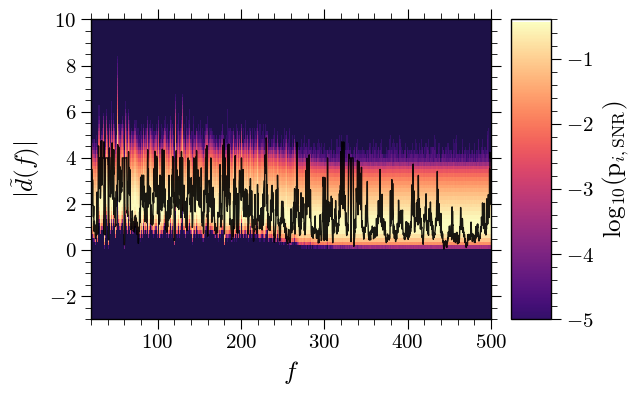

In [261]:
fig, ax1 = pf.create_plot()
ax1.set_xlabel(r'$f$')
ax2 = fig.add_axes((1.05, 0,0.1,1))
axs= [ax1,ax2]

mesh = ax1.pcolormesh(position_grid.T, amplitude_grid.T, plot, cmap='magma', vmin=-6)
fig.colorbar(mesh,cax=ax2, shrink=0.8, label=lab[q])
ax2.set_ylim([-5,-0.4])
ax1.set_xlim([20,500])
ax1.set_ylim([-3,10])

ax1.set_ylabel(r'$|\tilde{d}(f)|$')

interpolator = interp1d(hfilt.asd().frequencies, hfilt.asd().data)
gw150914 = interpolator(simulator.grid[:-10])/simulator.psdnorm[:-10]*np.sqrt(2)
interp_gw150914 = interp1d(simulator.grid[:-10], gw150914)
gw150914_2 = interp_gw150914(simulator.grid_chopped)

mask = gw150914>5
gw150914[mask]=4

mask_2 = gw150914_2>5
gw150914_2[mask_2]=4

ax1.plot(simulator.grid_chopped, gw150914_2, lw=1, color='k', alpha=0.9)


pf.fix_plot([ax3])
local_fix_plot(axs, tickdir='out')

In [256]:
gw_dict = {'x':torch.tensor(gw150914_2).unsqueeze(0)}
tvals = get_snr2(gw_dict).squeeze(0)

In [257]:
ts_bin_H0_epsilon

array([[5.12528256e-01, 4.22298709e-01, 7.96079417e-01, ...,
        7.61467951e-04, 1.27562014e+00, 8.95742165e-01],
       [1.78144626e+00, 4.50676378e-01, 2.72481563e+00, ...,
        1.28788021e+00, 9.89133184e-01, 6.99430467e-02],
       [8.54951917e+00, 4.47508098e+00, 3.69077077e+00, ...,
        5.18564603e-01, 5.78699544e-02, 1.67750417e+00],
       ...,
       [1.25259731e-01, 1.97396923e+00, 1.59171611e+00, ...,
        2.89824788e+00, 4.71840739e-02, 3.28864281e-01],
       [4.44479548e+00, 5.98688102e-02, 2.71517867e+00, ...,
        1.96619843e+00, 5.88705105e+00, 9.59703002e-03],
       [8.62665411e+00, 3.23838173e-02, 9.19465453e+00, ...,
        1.90277648e-02, 3.10657982e-03, 3.04570426e-01]],
      shape=(200000, 1960))

In [258]:
def precompute_centered_null(ts_bin_H0_epsilon):
    """
    Performs the one-time centering of the null distribution samples.

    This function takes the raw samples from a null hypothesis distribution,
    computes the mean of these samples, and subtracts it, effectively
    centering the distribution around zero. This is a useful pre-processing
    step before calculating empirical p-values.

    Args:
        ts_bin_H0_epsilon (np.ndarray): A 2D NumPy array where each row is a
                                        sample from the null hypothesis and
                                        each column is a different bin or feature.

    Returns:
        np.ndarray: The centered null distribution, with the same shape as the input.
    """
    eps_t_mean = np.mean(ts_bin_H0_epsilon, axis=0)
    return ts_bin_H0_epsilon - eps_t_mean


def calculate_pvalue_from_ref(observed_stats, centered_null_dist):
    """
    Calculates empirical p-values against a pre-computed centered null distribution.

    This function compares a 1D array of observed test statistics against a
    pre-computed null distribution to calculate empirical p-values. The p-value
    for each statistic is the proportion of samples in the null distribution
    that are at least as extreme as the observed statistic.

    Args:
        observed_stats (np.ndarray): A 1D NumPy array of observed test statistics.
        centered_null_dist (np.ndarray): The pre-computed centered null distribution
                                         (output of precompute_centered_null).

    Returns:
        np.ndarray: A 1D NumPy array of corresponding p-values.
    """
    # Count how many null statistics are greater than or equal to the observed statistics.
    # The `observed_stats` array is broadcasted across all rows of `centered_null_dist`.
    counts = np.sum(centered_null_dist >= observed_stats, axis=0)

    # Calculate the empirical p-value using the formula (counts + 1) / (n_samples + 1)
    # to avoid p-values of zero.
    n_samples = len(centered_null_dist)
    p_values = (counts + 1) / (n_samples + 1)

    return p_values

In [259]:
centered_null = precompute_centered_null(ts_bin_H0_epsilon)
p_values = calculate_pvalue_from_ref(tvals, centered_null)

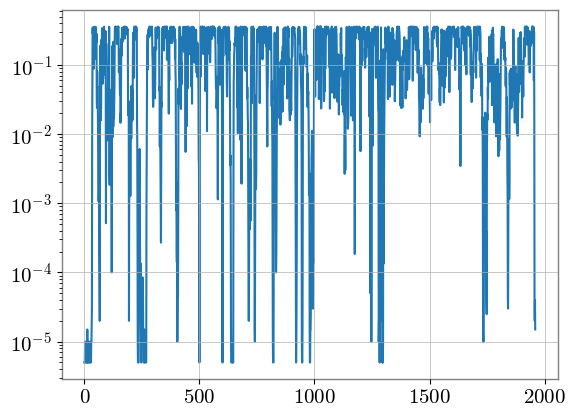

In [260]:
plt.semilogy(p_values)